In [146]:
import pandas as pd
import numpy as np
M=10000
#data = pd.read_csv('train_2011_2012_2013.csv',delimiter=';',usecols=['DATE','ASS_ASSIGNMENT','CSPL_RECEIVED_CALLS'], nrows=M)
data = pd.read_csv('train_2011_2012_2013.csv',delimiter=';',usecols=['DATE','ASS_ASSIGNMENT','CSPL_RECEIVED_CALLS'])

In [147]:
d = pd.DataFrame(data.groupby(['DATE', 'ASS_ASSIGNMENT'])['CSPL_RECEIVED_CALLS'].sum())
d.reset_index(level=0, inplace=True)
d.reset_index(level=0, inplace=True)
data = d

In [148]:
import time
data['time'] = data['DATE'].apply(lambda x: time.strptime(x, '%Y-%m-%d %H:%M:%S.000'))
data['day_week'] = data['time'].apply(lambda x: time.strftime("%w", x))
data['month'] = data['time'].apply(lambda x: time.strftime("%m", x))

In [149]:
data['ASS_ASSIGNMENT'].value_counts()

Téléphonie                        48497
Médical                           48478
Domicile                          48478
Nuit                              48478
Services                          48476
Tech. Inter                       48476
RENAULT                           48476
Japon                             48433
Gestion                           48093
SAP                               47661
Tech. Axa                         47516
Gestion - Accueil Telephonique    47225
Gestion Renault                   46285
Regulation Medicale               46249
Tech. Total                       44653
Gestion Assurances                40879
Manager                           40441
Gestion Clients                   33614
Gestion Relation Clienteles       32149
Gestion DZ                        31931
Mécanicien                        27131
RTC                               21589
CAT                               21503
CMS                               18803
Crises                            17792


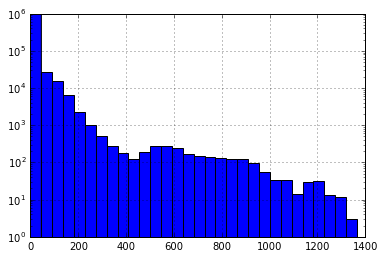

In [150]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.yscale('log')
data['CSPL_RECEIVED_CALLS'].hist(bins=30)

In [131]:
### New features: dummies for the day of the week, ASS_ASSIGNMENT, months

data = pd.concat((data, pd.get_dummies(data['day_week'])),axis=1)
data = pd.concat((data, pd.get_dummies(data['ASS_ASSIGNMENT'])),axis=1)
data = pd.concat((data, pd.get_dummies(data['month'])),axis=1)

In [152]:
data['H-M'] = data['time'].apply(lambda t: time.strftime("%H-%M", t))

In [153]:
### New feature: hours since the start of the day

data['hours'] = data['time'].apply(lambda x: float(time.strftime("%H", x))+np.sign(float(time.strftime("%M", x)))*0.5)

In [154]:
data['hours'].value_counts()

14.0    23958
14.5    23930
13.5    23923
13.0    23901
12.0    23901
12.5    23899
15.0    23893
15.5    23861
11.5    23831
11.0    23831
10.5    23796
10.0    23776
16.0    23767
9.5     23661
9.0     23650
16.5    23473
17.0    23319
8.5     23155
17.5    23061
8.0     22637
18.0    22582
7.5     22562
18.5    21643
19.0    21315
7.0     20819
19.5    20626
20.0    20260
23.0    20199
23.5    19953
22.5    19935
22.0    19873
20.5    19870
21.0    19724
21.5    19702
0.0     19358
0.5     19305
6.5     19303
1.0     19250
6.0     19197
5.5     19153
4.5     19152
4.0     19147
3.5     19142
1.5     19137
5.0     19120
3.0     19106
2.0     19103
2.5     19070
Name: hours, dtype: int64

In [155]:
### date scince epoch
data['time_absolut'] = data['time'].apply(time.mktime)

In [159]:
time.gmtime(data['time_absolut'].max())

time.struct_time(tm_year=2013, tm_mon=12, tm_mday=31, tm_hour=22, tm_min=30, tm_sec=0, tm_wday=1, tm_yday=365, tm_isdst=0)

In [160]:
time.gmtime(data['time_absolut'].min())

time.struct_time(tm_year=2010, tm_mon=12, tm_mday=31, tm_hour=23, tm_min=0, tm_sec=0, tm_wday=4, tm_yday=365, tm_isdst=0)

In [156]:
### New feature: average number of calls during h hours before the time for the specific category

def get_window1(x, h):
    interval = h*3600
    tmp = data[data['ASS_ASSIGNMENT'] == x['ASS_ASSIGNMENT']]
    tmp = tmp[tmp['time_absolut'] >= x['time_absolut']-interval]
    tmp = tmp[tmp['time_absolut'] <= x['time_absolut']]
    return tmp['CSPL_RECEIVED_CALLS'].mean()

data['mean_calls_6h_past_time'] = data[['time_absolut','ASS_ASSIGNMENT','CSPL_RECEIVED_CALLS']].apply(lambda p: get_window1(p, 6),axis=1)

KeyboardInterrupt: 

In [ ]:
data['mean_calls_6h_past_time']

In [99]:
### New feature: average over all the dates for the specific category and time

def get_window(x):
    tmp = data[data['ASS_ASSIGNMENT'] == x['ASS_ASSIGNMENT']]
    return tmp[tmp['H-M'] == x['H-M']]['CSPL_RECEIVED_CALLS'].mean()

data['mean_calls_time_ASS'] = data[['H-M','ASS_ASSIGNMENT','CSPL_RECEIVED_CALLS']].apply(get_window,axis=1)

In [124]:
#data[['mean_calls_time_ASS', 'DATE','ASS_ASSIGNMENT']]

In [123]:
#pp = data[data['H-M']=="00-00"]
#pp = pp[pp['ASS_ASSIGNMENT']=="Nuit"]
#pp['CSPL_RECEIVED_CALLS']

In [ ]:
### New feature: average over all the dates for the specific time

def get_window(x):
    tmp = data
    return tmp[tmp['H-M'] == x['H-M']]['CSPL_RECEIVED_CALLS'].mean()

data['mean_calls_time'] = data[['H-M','ASS_ASSIGNMENT','CSPL_RECEIVED_CALLS']].apply(get_window,axis=1)

In [125]:
#data[['mean_calls_time_ASS', 'DATE', 'ASS_ASSIGNMENT']]

In [103]:
indexes = np.concatenate((data.day_week.unique(), data.ASS_ASSIGNMENT.unique()))
indexes = np.concatenate((data.day_week.unique(), data.ASS_ASSIGNMENT.unique()))

In [133]:
from sklearn.ensemble import RandomForestRegressor as rf
from sklearn.cross_validation import train_test_split

X = data[indexes]
Y = data['CSPL_RECEIVED_CALLS']
X_train, X_test, y_train, y_test = train_test_split(X,Y)

In [134]:
model = rf()
model.fit(X_train,y_train)
pred = model.predict(X_test)

In [135]:
pred = np.round(pred)

In [136]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
r2_score(y_test, pred)
#mean_squared_error(y_test, pred)

1.6000000000000001

In [137]:
#y_test

In [138]:
data_sub = pd.read_table('submission.txt')

In [147]:
data.day_week.unique()

array(['0', '1', '6', '2', '3', '4', '5'], dtype=object)

In [151]:
indexes = np.concatenate((data.day_week.unique(), data.ASS_ASSIGNMENT.unique()))
                     
X_sub = data_sub[indexes]

KeyError: "['Gestion Amex'] not in index"

In [142]:
X_sub

,0,2,3,4,5,6
0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0
5,0.0,0.0,0.0,0.0,1.0,0.0
6,0.0,0.0,0.0,0.0,1.0,0.0
7,0.0,0.0,0.0,0.0,1.0,0.0
8,0.0,0.0,0.0,0.0,1.0,0.0
9,0.0,0.0,0.0,0.0,1.0,0.0


In [126]:
pred = model.predict(X_sub)
pred = np.round(pred)

ValueError: Number of features of the model must  match the input. Model n_features is 6 and  input n_features is 12 

In [123]:
pred

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0

In [100]:
data_sub = pd.read_table('submission.txt')